Deep Learning Text-Based Toxicity
- CSV format dataset from Kaggle Toxicity Challenge posted by Jigsaw
- Have a series of comments as strings
    - They have multi output labels to the strings that have different outcomes to grade toxicity
    - Labels will be multi binary
    - Creates matrices or array of scores [0, 1, 0, 0]
- Preprocessing step called tokenization – take inputs (strings) and convert to tokens
    - Converts words into sequences of integers
    - Layer/helper function performs this tokenization and preprocessing steps for us
    - Convert these tokens into events
    - Have embeddings (another vector) that represents attributes of the word that the DL network learns
- Tokens and embeddings get passed to Deep NN
    - Uses LSTM layers since they are good at working with sequences of embeddings
    - Final output – series of multiple binary outcomes that map to labels
    - Then serialize it to H5 format which allows us to save Deep NN to our disc
- Then convert to Gradio app

# 0. Install Dependencies and Bring in Data

In [1]:
!pip install tensorflow pandas matplotlib

  Using cached tensorflow-2.16.1-cp311-cp311-macosx_12_0_arm64.whl.metadata (4.1 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.5.4-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached h5py-3.11.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (2.5 kB)
  Using cached libclang-18.1.1-py2.py3-none-macosx_11_0_arm64.whl.metadata (5.2 kB)
  Using cached ml_dtypes-0.3.2-cp311-cp311-macosx_10_9_universal2.whl.metadata (20 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached termcolor-2.4.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached grpcio-1.64.0-cp311-cp311-macosx_10_9_universal2.whl.metadata (3.3 kB)
  Using cached tensorboard-2.16.2-py3-none-any.whl.metadata (1.6 kB)
  Using cached keras-3.3.3-py3-n

In [6]:
!pip list

Package                           Version
--------------------------------- ------------
absl-py                           2.1.0
aiobotocore                       2.7.0
aiohttp                           3.9.3
aioitertools                      0.7.1
aiosignal                         1.2.0
alabaster                         0.7.12
altair                            5.0.1
anaconda-anon-usage               0.4.3
anaconda-catalogs                 0.2.0
anaconda-client                   1.12.3
anaconda-cloud-auth               0.1.4
anaconda-navigator                2.5.2
anaconda-project                  0.11.1
anyio                             4.2.0
appdirs                           1.4.4
applaunchservices                 0.3.0
appnope                           0.1.2
appscript                         1.1.2
archspec                          0.2.1
argon2-cffi                       21.3.0
argon2-cffi-bindings              21.2.0
arrow                             1.2.3
astroid                   

In [5]:
import os # for working with file paths
import pandas as pd # helps read in tabular data (csvs)
import tensorflow as tf # deep learning framework, specifically keras
import numpy as np

In [9]:
# Alternative for CUDA: Apple's Metal Performance Shaders (MPS) framework for GPU acceleration on macOS
import torch

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS backend is available. Using MPS.")
else:
    device = torch.device("cpu")
    print("MPS backend is not available. Using CPU.")

MPS backend is available. Using MPS.


In [8]:
# using training data for testing and validation as well !!
df = pd.read_csv(os.path.join('jigsaw-toxic-comment-classification-challenge','train.csv', 'train.csv'))

In [11]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [13]:
df.iloc[0]['comment_text'] # iloc=integer location indexer

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [15]:
df[df.columns[2:]].iloc[0]

toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
Name: 0, dtype: int64

# 1. Preprocess

In [42]:
from tensorflow.keras.layers import TextVectorization # this import makes tokenization of NLP easier
# to convert words into numeric codes

In [41]:
TextVectorization??

Init signature:
TextVectorization(
    max_tokens=None,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    ngrams=None,
    output_mode='int',
    output_sequence_length=None,
    pad_to_max_tokens=False,
    vocabulary=None,
    idf_weights=None,
    sparse=False,
    ragged=False,
    encoding='utf-8',
    name=None,
    **kwargs,
)
Source:        
@keras_export("keras.layers.TextVectorization")
class TextVectorization(Layer):
    """A preprocessing layer which maps text features to integer sequences.

    This layer has basic options for managing text in a Keras model. It
    transforms a batch of strings (one example = one string) into either a list
    of token indices (one example = 1D tensor of integer token indices) or a
    dense representation (one example = 1D tensor of float values representing
    data about the example's tokens). This layer is meant to handle natural
    language inputs. To handle simple string inputs (categorical strings or
    pr

In [44]:
# Want to split data into comments and features
X = df['comment_text']
y = df[df.columns[2:]].values
print("X:", X)
print("y:", y)

X: 0         Explanation\nWhy the edits made under my usern...
1         D'aww! He matches this background colour I'm s...
2         Hey man, I'm really not trying to edit war. It...
3         "\nMore\nI can't make any real suggestions on ...
4         You, sir, are my hero. Any chance you remember...
                                ...                        
159566    ":::::And for the second time of asking, when ...
159567    You should be ashamed of yourself \n\nThat is ...
159568    Spitzer \n\nUmm, theres no actual article for ...
159569    And it looks like it was actually you who put ...
159570    "\nAnd ... I really don't think you understand...
Name: comment_text, Length: 159571, dtype: object
y: [[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 ...
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


In [45]:
# Specifying how many words we want to store, efficiency vs ram/space
MAX_FEATURES = 200000 # number of words in the vocab

In [46]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800, # max length of sentence in words
                               output_mode='int') # map words to integer

In [47]:
vectorizer.adapt(X.values) # learning words, X.values converts panda series to array of strings

In [48]:
vectorized_text = vectorizer(X.values)

In [49]:
# Vectorizer lowers and strips punctuation, given in documentation
vectorizer("Hello world!")

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([288, 263,   0, ...,   0,   0,   0])>

In [50]:
vectorized_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  645,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2489, ...,     0,     0,     0],
       [  425,   441,    70, ...,     0,     0,     0],
       ...,
       [32445,  7392,   383, ...,     0,     0,     0],
       [    5,    12,   534, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]])>

In [51]:
# Creating a TensorFlow dataset pipeline, useful for data that doesn't fit in memory
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
# mapping: applying transformation to each element
# caching: saves time by storing transformed data
# shuffling: stops model from learning order of the data
# batching: groups data into batches for efficiency
# prefetching: overlaps preprocessing/model execution of a batch with data loading of next batch using idle GPU/CPU
# decrs loading latency (loading into memory and turnover) & bottlenecks, incrs throughput (data processed/unit time)
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [52]:
dataset.as_numpy_iterator().next() # getting one batch, outputs text in vectorized format and labels

(array([[2908,   23,   79, ...,    0,    0,    0],
        [ 562,  179,  136, ...,    0,    0,    0],
        [2388, 1064,  581, ...,    0,    0,    0],
        ...,
        [  98,  141,   98, ...,    0,    0,    0],
        [ 163,  340,    1, ...,    0,    0,    0],
        [ 433,    8,  244, ...,    0,    0,    0]]),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]))

In [53]:
len(dataset) # gives number of batches

9974

In [54]:
train = dataset.take(int(len(dataset)*.7)) # assigning 70% of length of dataset
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

# 2. Create Sequential Model

In [117]:
epoch_values = [1]
loss_values = [0.0487]
val_loss_values = [0.0440]

prediction_arrays = [[0.8943111 , 0.05602828, 0.6404689 , 0.03274197, 0.4891785 ,
        0.08741571]]

precision_values = [0.8856167197227478]
recall_values = [0.6166418790817261]
accuracy_values = [0.520561695098877]

In [55]:
from tensorflow.keras.models import Sequential # API to group linear stack of layers into a model
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding
# Layers used to build deep learning network:
# LSTM: long-short-term memory, captures long-term dependencies in sequence data
# Dropout: prevents overfitting by introducing noise during training
# Bidirectional: modifier, allows us to pass features from LSTM across the board both ways
#  - i.e., "hate" can be tagged as toxic but having "don't" in front would negate it, important for NLP
# Dense: connects layers
# Embedding: maps the word, knows a lot about a word, like a personality test for a word, also reduces dimensionality

In [56]:
Sequential??

Init signature: Sequential(*args, **kwargs)
Source:        
@keras_export(["keras.Sequential", "keras.models.Sequential"])
class Sequential(Model):
    """`Sequential` groups a linear stack of layers into a `Model`.

    Examples:

    ```python
    model = keras.Sequential()
    model.add(keras.Input(shape=(16,)))
    model.add(keras.layers.Dense(8))

    # Note that you can also omit the initial `Input`.
    # In that case the model doesn't have any weights until the first call
    # to a training/evaluation method (since it isn't yet built):
    model = keras.Sequential()
    model.add(keras.layers.Dense(8))
    model.add(keras.layers.Dense(4))
    # model.weights not created yet

    # Whereas if you specify an `Input`, the model gets built
    # continuously as you are adding layers:
    model = keras.Sequential()
    model.add(keras.Input(shape=(16,)))
    model.add(keras.layers.Dense(8))
    len(model.weights)  # Returns "2"

    # When using the delayed-build pattern (no input 

In [57]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32)) # number of words + 1, 1 embedding per word, embeddings are 32 values in len
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh'))) # LSTM needs GPU acceleration of tanh (dictated by TensorFlow)
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid')) # output 6 layers for 6 labels, sigmoid converts relu into 0 to 1 values

In [206]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam') # BinaryCrossentropy is reducing loss for binary outputs

In [207]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 1800, 32)       │     6,400,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,491,686 (24.76 MB)

 Trainable params: 6,491,686 (24.76 MB)

 Non-trainable params: 0 (0.00 B)

In [208]:
epoch=10
history = model.fit(train, epochs=epoch, validation_data=val) 
# epoch=1 how long to train for, how many passes through validation data

epoch_values.append(epoch)
loss_values.append(history.history['loss'])
val_loss_values.append(history.history['val_loss'])
                   

Epoch 1/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 4033s 577ms/step - loss: 0.0093 - val_loss: 0.0070
Epoch 2/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 2485s 356ms/step - loss: 0.0085 - val_loss: 0.0076
Epoch 3/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 2535s 363ms/step - loss: 0.0076 - val_loss: 0.0061
Epoch 4/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 2502s 358ms/step - loss: 0.0069 - val_loss: 0.0061
Epoch 5/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 2512s 360ms/step - loss: 0.0066 - val_loss: 0.0053
Epoch 6/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 2561s 367ms/step - loss: 0.0064 - val_loss: 0.0049
Epoch 7/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 2471s 354ms/step - loss: 0.0058 - val_loss: 0.0049
Epoch 8/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 2475s 354ms/step - loss: 0.0057 - val_loss: 0.0049
Epoch 9/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 2474s 354ms/step - loss: 0.0052 - val_loss: 0.0042
Epoch 10/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 2535s 363ms/step - loss: 0.0049 - val_loss: 0.0039


epoch=1, 3982s

epoch1/5, 4362s\
epoch2/5, 4407s\
epoch3/5, 4296s\
epoch4/5, 19645s\
epoch5/5, 3562s

epoch10 average of 2500s overnight

In [67]:
from matplotlib import pyplot as plt

In [209]:
history.history['loss']

[0.009800473228096962,
 0.00886597577482462,
 0.007894575595855713,
 0.007385097444057465,
 0.006942014675587416,
 0.006665321532636881,
 0.006064769811928272,
 0.0060945358127355576,
 0.005610900465399027,
 0.005176398437470198]

<Figure size 800x500 with 0 Axes>

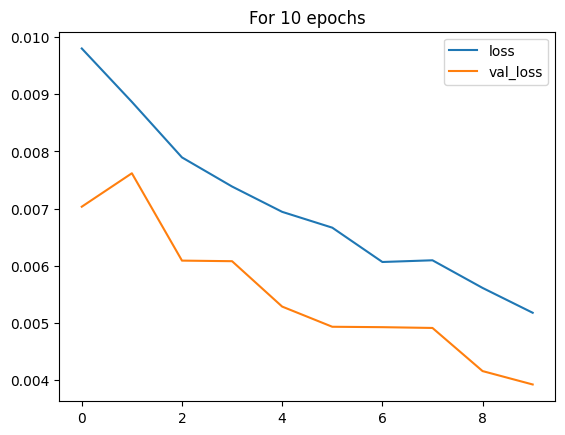

In [213]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.title("For 10 epochs")
plt.show()

# 3. Make Predictions

In [214]:
input_text = vectorizer('You freaking suck! I am going to hit you')

In [215]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [216]:
res = model.predict(np.expand_dims(input_text, 0))
prediction_arrays.append(res)
res

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


array([[0.9999831 , 0.7744125 , 0.99351764, 0.8125012 , 0.95558053,
        0.01734824]], dtype=float32)

In [217]:
res = model.predict(np.expand_dims(input_text, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [218]:
prediction_arrays

[[0.8943111, 0.05602828, 0.6404689, 0.03274197, 0.4891785, 0.08741571],
 array([[0.9976949 , 0.3252377 , 0.96076703, 0.05585683, 0.8893708 ,
         0.15761106]], dtype=float32),
 array([[0.9999831 , 0.7744125 , 0.99351764, 0.8125012 , 0.95558053,
         0.01734824]], dtype=float32)]

In [219]:
(res > 0.5).astype(int)

array([[1, 1, 1, 1, 1, 0]])

In [220]:
batch_X, batch_y = test.as_numpy_iterator().next() # grabbing another batch to run prediction again

In [221]:
(model.predict(batch_X) > 0.5).astype(int) # seeing which ones pass (>0.5) and putting them into binary form

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 1, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [222]:
res.shape

(1, 6)

# 4. Evaluate Model

In [139]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
# metrics
# Precision: ratio of correctly predicted positive observations to the total predicted positive
# Recall: ratio of correctly predicted positive observations to the all observations
# CategoricalAccuracy: calculates the percentage of predictions that match the true labels

In [140]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [223]:
# Loop through each batch in pipeline
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions, making one big vector
    y_true = y_true.flatten()
    yhat = yhat.flatten()

    # grabbing precision metric and updating the metric based on current batch of data
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━

2024-05-29 09:26:10.002726: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [224]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')
precision_values.append(pre.result().numpy())
recall_values.append(re.result().numpy())
accuracy_values.append(acc.result().numpy())

Precision: 0.944403350353241, Recall:0.9116471409797668, Accuracy:0.5461384057998657


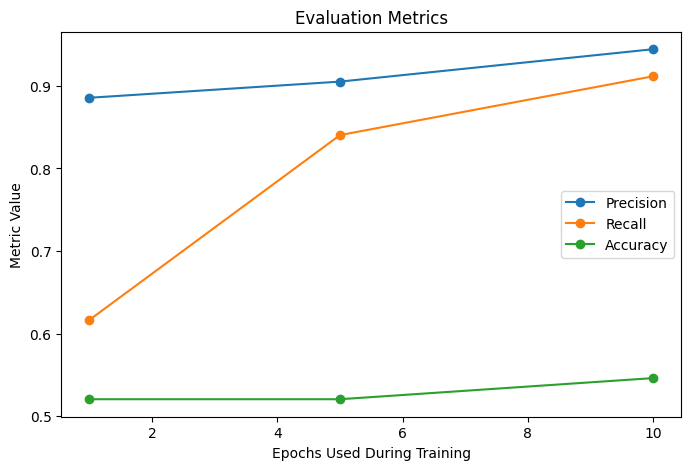

In [231]:
plt.figure(figsize=(8,5))
plt.plot(epoch_values, precision_values, label='Precision', marker='o')
plt.plot(epoch_values, recall_values, label='Recall', marker='o')
plt.plot(epoch_values, accuracy_values, label='Accuracy', marker='o')
plt.title("Evaluation Metrics")
plt.xlabel("Epochs Used During Training")
plt.ylabel("Metric Value")
plt.legend()

In [239]:
accuracy_values

[0.520561695098877, 0.5205617, 0.5461384]

In [180]:
avg_loss_values=[]
avg_val_loss_values=[]

In [232]:
for i in range(len(epoch_values)):
    avg_loss_values.append(np.average(loss_values[i]))
    avg_val_loss_values.append(np.average(val_loss_values[i]))

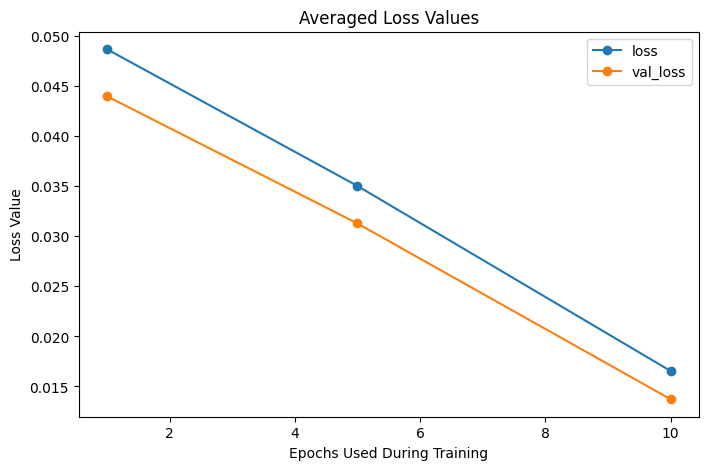

In [238]:
plt.figure(figsize=(8,5))
plt.plot(epoch_values, avg_loss_values, label='loss', marker='o') #training loss
plt.plot(epoch_values, avg_val_loss_values, label='val_loss', marker='o') #validation loss
plt.title("Averaged Loss Values")
plt.xlabel("Epochs Used During Training")
plt.ylabel("Loss Value")
plt.legend()

# 5. Test and Gradio

In [92]:
!pip install gradio jinja2

  Preparing metadata (setup.py) ... done
  Using cached httpx-0.27.0-py3-none-any.whl.metadata (7.2 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.3/107.3 kB 1.3 MB/s eta 0:00:00a 0:00:01
  Using cached httpcore-1.0.5-py3-none-any.whl.metadata (20 kB)
  Using cached h11-0.14.0-py3-none-any.whl.metadata (8.2 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 3.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.9/315.9 kB 3.8 MB/s eta 0:00:00a 0:00:01
Using cached httpx-0.27.0-py3-none-any.whl (75 kB)
Using cached httpcore-1.0.5-py3-none-any.whl (77 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.3/401.3 kB 3.8 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.6/253.6 kB 6.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.3/409.3 kB 6.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 

In [196]:
# import tensorflow as tf
import gradio as gr

In [197]:
model.save('toxicity.h5')

In [198]:
model = tf.keras.models.load_model('toxicity.h5')

In [199]:
input_str = vectorizer('hey i freaken hate you!')

In [200]:
res = model.predict(np.expand_dims(input_str,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


In [201]:
res

array([[0.9538674 , 0.0025544 , 0.03101719, 0.00500237, 0.07819529,
        0.00111897]], dtype=float32)

In [202]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [203]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

AttributeError: module 'gradio' has no attribute 'inputs'

In [105]:
interface.launch(share=True)

NameError: name 'interface' is not defined

Questions to think about:
- running for more epochs or data? safe for machine? how to make this work faster?
- does this model fit our needs? need to determine appropriate probability that results in "true"